In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import time 
from multiprocessing import Pool
from scipy.optimize import minimize
from collections import defaultdict


In [3]:
def logistic(z, theta):
    return 1 / (1 + np.exp(-np.matmul(theta, z.T)))

#p_s = logistic(customer_features, true_ad_features)
#p_hat = logistic(customer_features, estimated_ad_features) 
def compute_cost(X, y, theta):
    m = len(y)
    h = sigmoid(X @ theta)
    epsilon = 1e-5  # small constant to prevent log(0)
    cost = (1/m) * (-y.T @ np.log(h + epsilon) - (1 - y).T @ np.log(1 - h + epsilon))
    return cost

# Define the gradient descent function
def gradient_descent(X, y, theta, learning_rate, num_iterations):
    m = len(y)
    #cost_history = np.zeros(num_iterations)
    
    for i in range(num_iterations):
        gradient = (1/m) * (X.T @ (logistic(X , theta) - y))
        theta = theta - learning_rate * gradient
        #cost_history[i] = compute_cost(X, y, theta)
    
    return theta



In [35]:
def dp(p_s,rewards1,budgets_org,num_customers):
    dp = pd.DataFrame({'merchant': np.arange(0, 200),  'budgets': budgets_org})
    # Step 1: Create a 5x4 numpy matrix
    matrix = np.round(p_s * rewards1, 10)
    # Step 2: Convert the numpy matrix to a pandas DataFrame
    df = pd.DataFrame(matrix)
    # Step 3: Set the column names to 'site_1', 'site_2', 'site_3', and 'site_4'
    df.columns = [f'site_{i}' for i in range(0, num_customers)]
    dp = pd.concat([dp, df], axis=1)
    return dp

In [36]:
def optimal(dp,visits):
    
    budge=dp['budgets'].values.astype(float)
    visits['revenue_org'] = 0.0
    for i in range(len(visits)):
    
        if i%1000==0:
            print(i)
            #print(budge)
        
        site=visits.loc[i, 'site']
        Max,indexx=dp['site_'+str(site)].max(),dp['site_'+str(site)].idxmax()
        merchant=dp.loc[indexx, 'merchant']
        
        if budge[merchant]-Max>0:
    
            visits.at[i, 'revenue_org']=Max
            budge[merchant]=budge[merchant]-Max
            #print(budge)
            #print(merchant)
        else:
            #print('aa:',budge[merchant])
            #print('b:',budge,merchant)
            visits.at[i, 'revenue_org']=budge[merchant]
            dp.drop(index=indexx, inplace=True)
            budge[merchant] =0   
    
        if len(dp)==0:
            break
        
    return visits  

In [37]:
def evaluation(visits,visits_opt):

   return visits['revenue'].sum()/visits_opt['revenue_org'].sum()
    
    

In [69]:
def simulation(l,d,customer_id,batch):
# Set random seed for reproducibility
    np.random.seed(0)
    
    # Parameters
    num_customers = l
    num_ads = 200
    d = d  # Dimensionality of feature vectors
    mu_z =np.zeros(d)
    Sigma_z = np.eye(d)
    mu_theta = np.zeros(d)
    Sigma_theta = np.eye(d)
    mu_0 = np.zeros(d)
    Sigma_0 = np.eye(d)
    
    np.random.seed(0)
    budgets = np.random.randint(100, 150, num_ads).astype(float)
    budgets_org = budgets.copy()

    np.random.seed(0)
    rewards = np.minimum(np.round(np.exp(np.random.normal(1, 1, (num_ads, num_customers))), 5),
                         budgets.reshape(num_ads, 1)).astype(float)
    
    rewards1 = rewards.copy()
    
    #lambda_j = 1000 * np.random.rand(num_customers)
    #lambda_j /= np.sum(lambda_j)
    
    # Generate customer feature vectors
    np.random.seed(0)
    #customer_features = np.random.multivariate_normal(mu_z, Sigma_z, num_customers)
    customer_features = np.random.randint(low=0, high=2, size=(num_customers,d))
    
    # Generate true ad feature vectors (these are unknown and to be estimated)
    np.random.seed(0)
    true_ad_features = np.random.multivariate_normal(mu_theta, Sigma_theta, num_ads)
    
    # Initialize estimates for ad feature vectors
    np.random.seed(0)
    sampled_thetas = estimated_ad_features = np.random.multivariate_normal(mu_0, Sigma_0, num_ads)
    cov_matrices = [Sigma_0 for _ in range(num_ads)]
    
    impressions = np.zeros((num_ads, num_customers), dtype=int)
    clicks = np.zeros((num_ads, num_customers), dtype=int)
    horizon = num_iterations = int(1e5)
    
    visits = pd.DataFrame({
        'site': np.zeros(horizon, dtype=int),
        'ads': np.zeros(horizon, dtype=int),
        'p_hat': np.zeros(horizon, dtype=float),
        'cost': np.zeros(horizon, dtype=float),
        'is_clicked': np.zeros(horizon, dtype=bool),  # Explicitly cast to boolean
        'revenue': np.zeros(horizon, dtype=float)
    })
    epsilon = 1e-10
    learning_rate=0.1
    temp_10=[]
    np.random.seed(0)
    p_s = np.random.beta(0.1, 9.9, (num_ads,num_customers))
    p_hat = logistic(customer_features, estimated_ad_features) 
    for t in range(num_iterations):
        if t % 1000 == 0:
            print(t)
        
        # Randomly select a customer
        #i = np.random.choice(num_customers, p=lambda_j)
        #z_i = customer_features[i]
        i = customer_id[t]
        z_i=customer_features[i]
    
        # Sample from the posterior to select an ad
        #sampled_thetas = [np.random.multivariate_normal(estimated_ad_features[j], cov_matrices[j]) for j in range(num_ads)]
        #ad_selected = np.argmax([logistic(z_i, theta) for theta in estimated_ad_features])
        ad_selected = np.argmax(p_hat[:, i] * rewards[:, i])
        
        # Observe the click based on the true ad feature vector
        true_click_prob = p_s[ad_selected, i]
        click = np.random.binomial(1, true_click_prob)
        impressions[ad_selected, i] += 1
        clicks[ad_selected, i] += click
        temp_10.append((ad_selected, i))
        #print(temp_10)
        
        
        if click:
            
            budgets[ad_selected] -= rewards[ad_selected,i]
            #print(rewards[ad,:],budgets[ad])
            rewards[ad_selected,:] = np.minimum(rewards[ad_selected,:], budgets[ad_selected])
        visits.at[t, 'site'] = i
        visits.at[t, 'ads'] = ad_selected
        visits.at[t, 'is_clicked'] = bool(click)
        visits.at[t, 'p_hat'] = p_hat[ad_selected, i]
        visits.at[t, 'cost'] = rewards[ad_selected, i]
        visits.at[t, 'revenue'] = rewards[ad_selected, i] * click
       
        
        # Update the posterior for the selected ad
        if (t % batch==0) and (t!=0): 
    
            dictionary = defaultdict(list)
        
            for key, value in temp_10:
                dictionary[key].append(value)
                
            for ads in  dictionary.keys():
                
                temp_p_hat=clicks[ads,dictionary[ads]] /impressions[ads,dictionary[ads]]
                estimated_ad_features[ads]=gradient_descent(customer_features[dictionary[ads]], temp_p_hat, estimated_ad_features[ads], learning_rate, 100)
                
            temp_10=[]
                    
                
            
            p_hat = logistic(customer_features, estimated_ad_features)


    return visits,rewards1,p_s
       

In [70]:
dict_100={}

In [71]:

start_time_vec = time.time()

for l in [1,2,10,20]:
    lambda_j = 1000 * np.random.rand(l)
    lambda_j /= np.sum(lambda_j)
    customer_id=np.random.choice(l, p=lambda_j,size=int(1e5))
    for d in [1,2,10,20]:

        dict_100[f'visit_{l}_{d}'],dict_100[f'rewards_{l}_{d}'],dict_100[f'p_s_{l}_{d}']=simulation(l,d,customer_id,batch=100)
        print(l,d)

end_time_vec = time.time()

time_vec = end_time_vec - start_time_vec







0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
1 1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70

In [72]:
np.random.seed(0)
dict_100_dp={}
budgets_org = np.random.randint(100, 150, 200).astype(float)

In [73]:
for l in [1,2,10,20]:
    for d in [1,2,10,20]:

        dict_100_dp[f'dp_{l}_{d}']=dp(dict_100[f'p_s_{l}_{d}'],dict_100[f'rewards_{l}_{d}'],budgets_org,l)

In [74]:
dict_100_optimal={}

In [75]:
for l in [1,2,10,20]:
    for d in [1,2,10,20]:

        dict_100_optimal[f'optimal_{l}_{d}']=optimal(dict_100_dp[f'dp_{l}_{d}'],dict_100[f'visit_{l}_{d}'])
        print(l,d)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
1 1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70

In [76]:
dict_100_evaluation={}

In [77]:
for l in [1,2,10,20]:
    for d in [1,2,10,20]:
        dict_100_evaluation[f'evaluation_{l}_{d}']=evaluation(dict_100[f'visit_{l}_{d}'],dict_100_optimal[f'optimal_{l}_{1}'])
        print(l,d)

1 1
1 2
1 10
1 20
2 1
2 2
2 10
2 20
10 1
10 2
10 10
10 20
20 1
20 2
20 10
20 20


In [78]:
pd.DataFrame(list(dict_100_evaluation.items()), columns=['Evaluation_l_1', 'Value'])

,Evaluation_l_1,Value
0,evaluation_1_1,0.032290
1,evaluation_1_2,0.685161
2,evaluation_1_10,0.763580
3,evaluation_1_20,0.778296
4,evaluation_2_1,0.222616
5,evaluation_2_2,0.625293
6,evaluation_2_10,0.704476
7,evaluation_2_20,0.598638
8,evaluation_10_1,0.327371
9,evaluation_10_2,0.389319


# Batch 1000

In [79]:
dict_1000={}

In [80]:
start_time_vec = time.time()

for l in [1,2,10,20]:
    lambda_j = 1000 * np.random.rand(l)
    lambda_j /= np.sum(lambda_j)
    customer_id=np.random.choice(l, p=lambda_j,size=int(1e5))
    for d in [1,2,10,20]:

        dict_1000[f'visit_{l}_{d}'],dict_1000[f'rewards_{l}_{d}'],dict_1000[f'p_s_{l}_{d}']=simulation(l,d,customer_id,batch=1000)
        print(l,d)

end_time_vec = time.time()

time_vec = end_time_vec - start_time_vec

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
1 1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70

In [58]:
'''
for l in [1,2,10,20]:
    for d in [1,2,10,20,30]:

        dict_1000[f'visit_{l}_{d}'],dict_1000[f'rewards_{l}_{d}'],dict_1000[f'p_s_{l}_{d}']=simulation(l,d)
        print(l,d)
'''        

"\nfor l in [1,2,10,20]:\n    for d in [1,2,10,20,30]:\n\n        dict_1000[f'visit_{l}_{d}'],dict_1000[f'rewards_{l}_{d}'],dict_1000[f'p_s_{l}_{d}']=simulation(l,d)\n        print(l,d)\n"

In [59]:
#w=pd.DataFrame({'p_s':p_s.reshape(-1,),'p_hat':p_hat.reshape(-1,)})
#w.sort_values(by='p_s', ascending=False).head(30)

In [85]:
np.random.seed(0)
dict_1000_dp={}
budgets_org = np.random.randint(100, 150, 200).astype(float)

In [86]:
for l in [1,2,10,20]:
    for d in [1,2,10,20]:

        dict_1000_dp[f'dp_{l}_{d}']=dp(dict_1000[f'p_s_{l}_{d}'],dict_1000[f'rewards_{l}_{d}'],budgets_org,l)

In [87]:
dict_1000_optimal={}

In [88]:
for l in [1,2,10,20]:
    for d in [1]:

        dict_1000_optimal[f'optimal_{l}_{d}']=optimal(dict_1000_dp[f'dp_{l}_{d}'],dict_1000[f'visit_{l}_{d}'])
        print(l,d)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
1 1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70

In [89]:
dict_1000_evaluation={}

In [91]:
for l in [1,2,10,20]:
    for d in [1,2,10,20]:
        dict_1000_evaluation[f'evaluation_{l}_{d}']=evaluation(dict_1000[f'visit_{l}_{d}'],dict_1000_optimal[f'optimal_{l}_{1}'])
        print(l,d)

1 1
1 2
1 10
1 20
2 1
2 2
2 10
2 20
10 1
10 2
10 10
10 20
20 1
20 2
20 10
20 20


In [92]:
pd.DataFrame(list(dict_1000_evaluation.items()), columns=['Evaluatio_l_d', 'Value'])

,Evaluatio_l_d,Value
0,evaluation_1_1,0.032290
1,evaluation_1_2,0.479822
2,evaluation_1_10,0.515435
3,evaluation_1_20,0.438499
4,evaluation_2_1,0.103893
5,evaluation_2_2,0.415936
6,evaluation_2_10,0.384616
7,evaluation_2_20,0.413129
8,evaluation_10_1,0.248924
9,evaluation_10_2,0.300521


In [93]:
pd.DataFrame(list(dict_100_evaluation.items()), columns=['Evaluation_l_d', 'Value'])

,Evaluation_l_d,Value
0,evaluation_1_1,0.032290
1,evaluation_1_2,0.685161
2,evaluation_1_10,0.763580
3,evaluation_1_20,0.778296
4,evaluation_2_1,0.222616
5,evaluation_2_2,0.625293
6,evaluation_2_10,0.704476
7,evaluation_2_20,0.598638
8,evaluation_10_1,0.327371
9,evaluation_10_2,0.389319


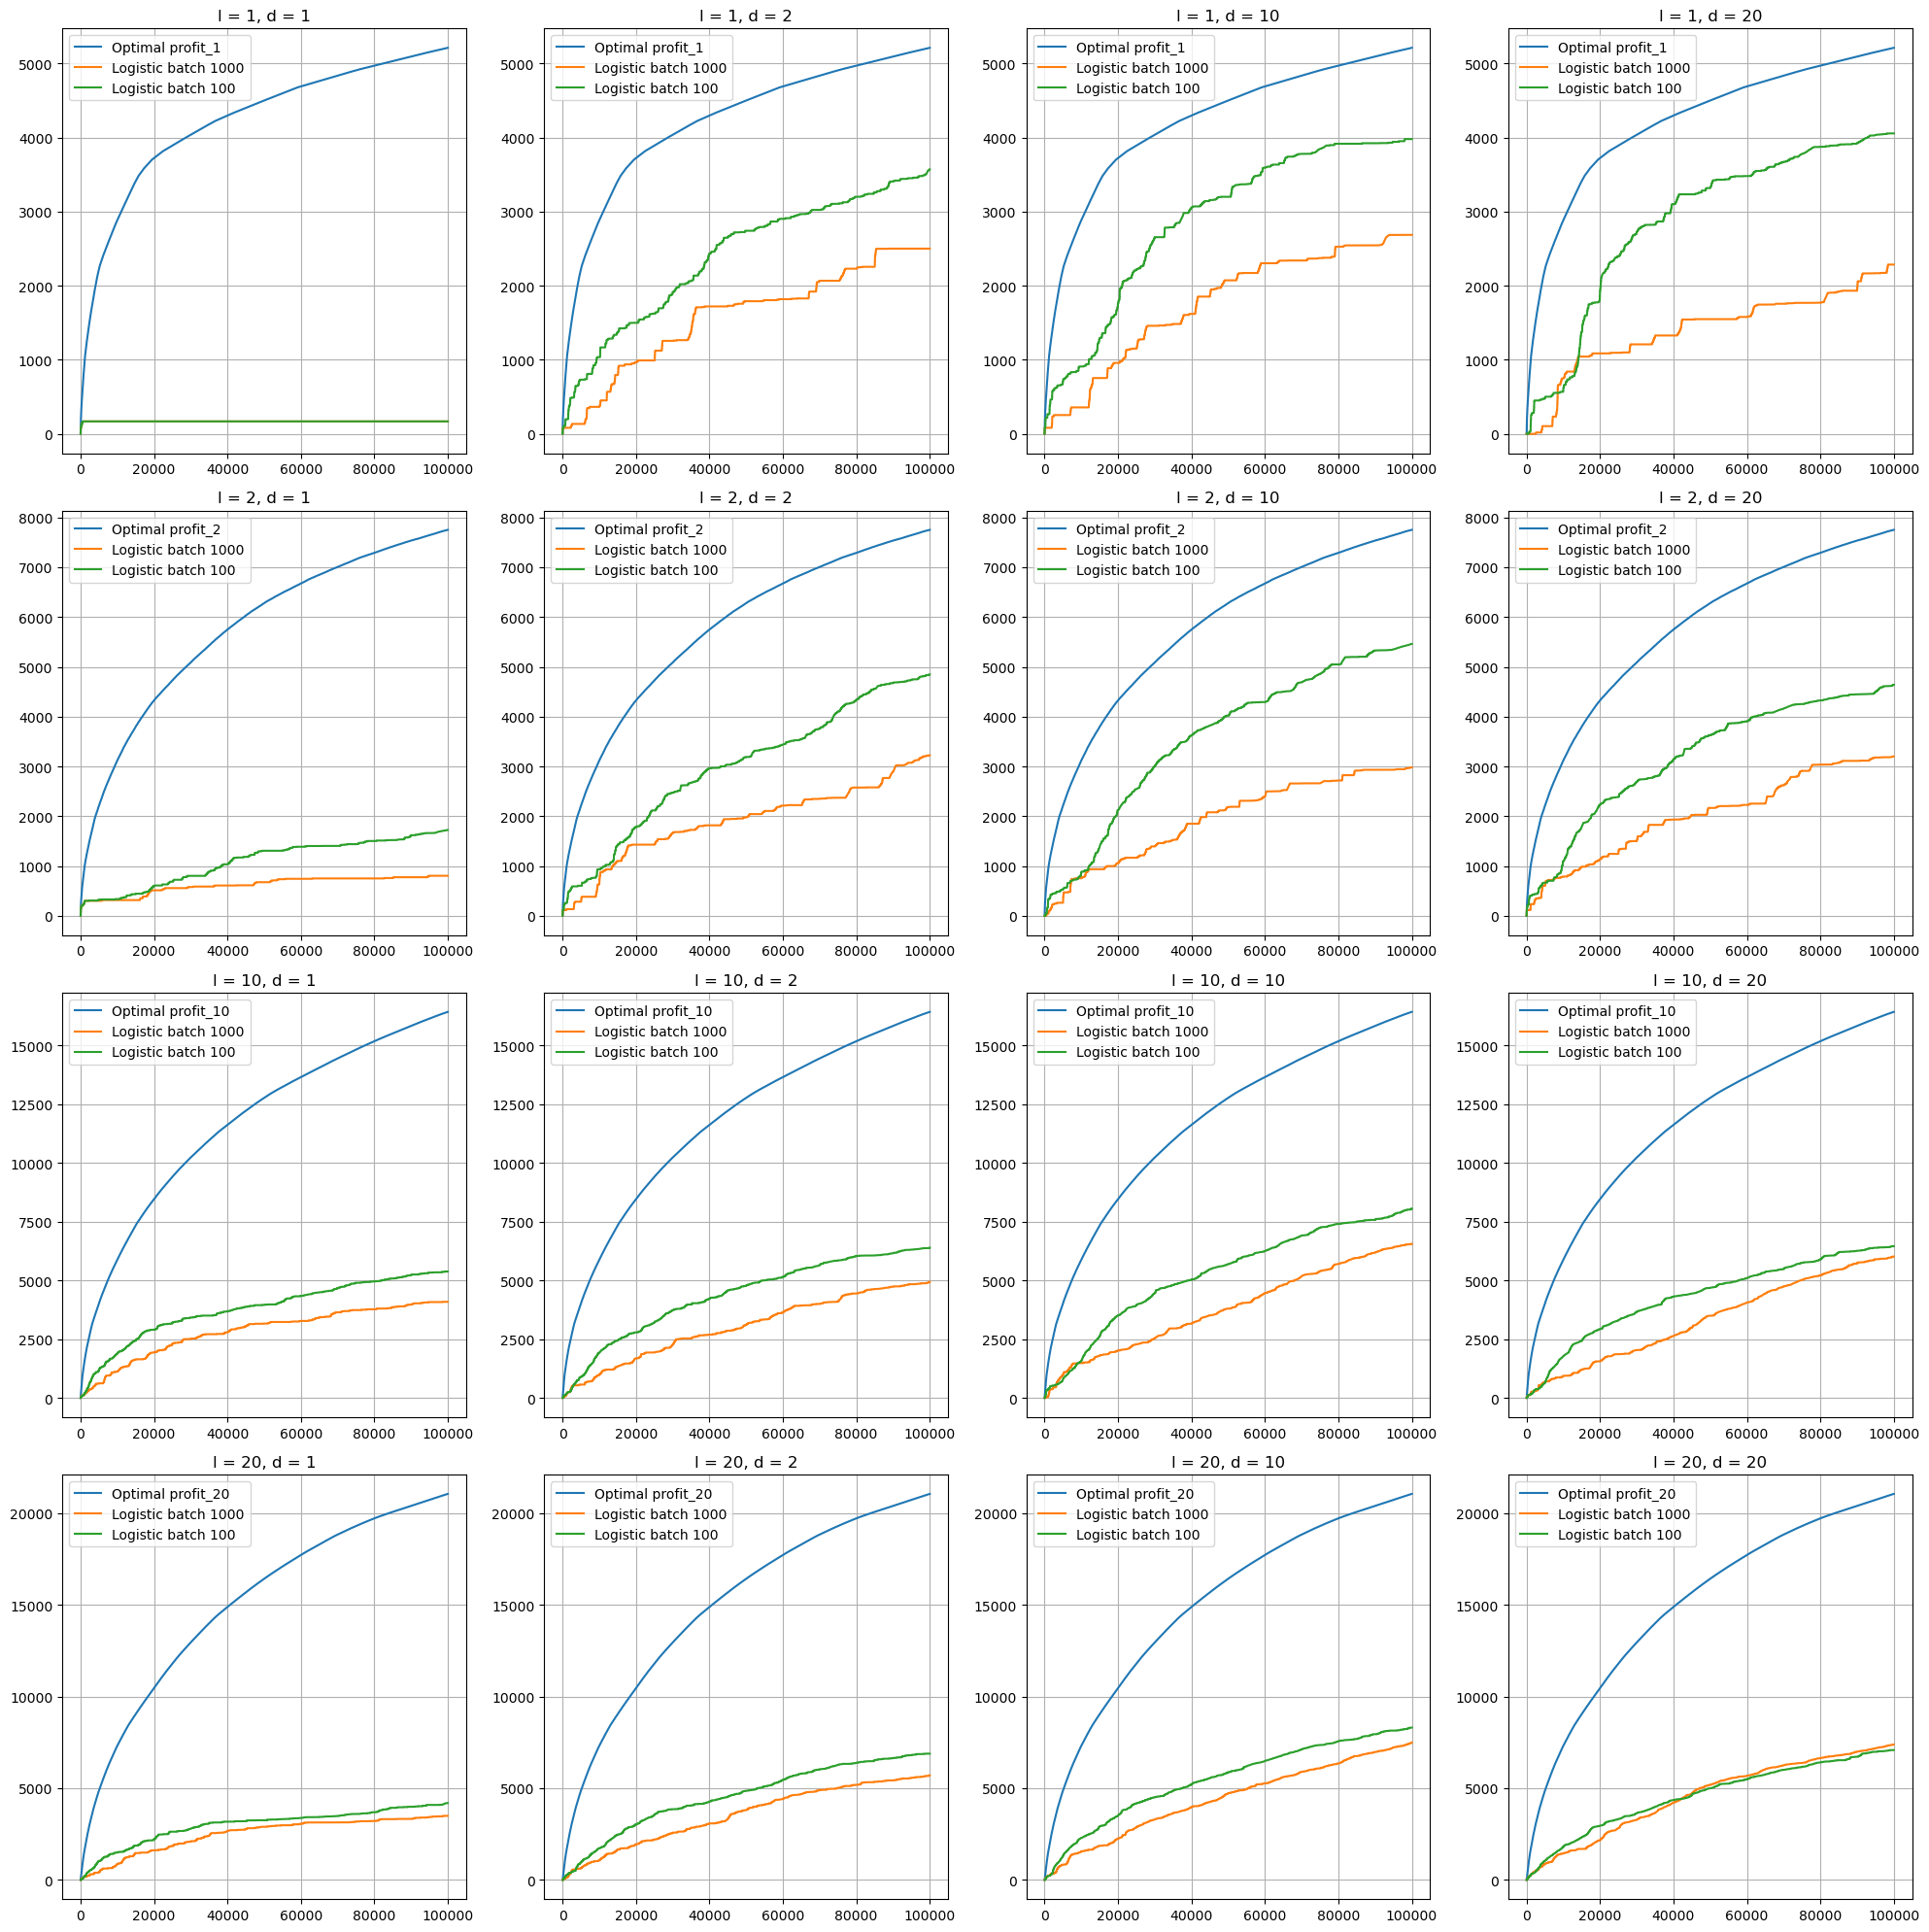

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Define the grid size
fig, axes = plt.subplots(4, 4, figsize=(20, 20))  # 4x4 grid, adjust figsize as needed
axes = axes.flatten()  # Flatten to make indexing easier

# Loop over the different `l` and `d` values
for i, l in enumerate([1, 2, 10, 20]):
    for j, d in enumerate([1, 2, 10, 20]):
        ax = axes[i*4 + j]  # Access the subplot
        
        # Plot the data
        ax.plot(np.arange(len(dict_1000_optimal[f'optimal_{l}_{1}'])),
                dict_1000_optimal[f'optimal_{l}_{1}']['revenue_org'].cumsum(),
                label=f'Optimal profit_{l}')
        
        ax.plot(np.arange(len(dict_1000[f'visit_{l}_{d}'])),
                dict_1000[f'visit_{l}_{d}']['revenue'].cumsum(),
                label=f'Logistic batch 1000')
        
        ax.plot(np.arange(len(dict_100[f'visit_{l}_{d}'])),
                dict_100[f'visit_{l}_{d}']['revenue'].cumsum(),
                label=f'Logistic batch 100')
        
        # Set the title for the subplot
        ax.set_title(f'l = {l}, d = {d}')
        ax.grid(True)
        ax.legend()

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


In [109]:
import pickle

# Define the directory path
directory_path = r'C:\Users\Nouri\Desktop\RL-PRO\Log'

# Save the dictionaries as pickle files
with open(f'{directory_path}\dict_1000_optimal.pkl', 'wb') as pickle_file:
    pickle.dump(dict_1000_optimal, pickle_file)

with open(f'{directory_path}\dict_1000.pkl', 'wb') as pickle_file:
    pickle.dump(dict_1000, pickle_file)

with open(f'{directory_path}\dict_100.pkl', 'wb') as pickle_file:
    pickle.dump(dict_100, pickle_file)


In [4]:
import pickle

# Define the directory path
directory_path = r'C:\Users\Nouri\Desktop\RL-PRO\Log'

# Load the dictionaries from the pickle files
with open(f'{directory_path}\dict_100.pkl', 'rb') as pickle_file:
    Lg_dict_100 = pickle.load(pickle_file)

with open(f'{directory_path}\dict_1000_optimal.pkl', 'rb') as pickle_file:
    Lg_optimal_dict_1000 = pickle.load(pickle_file)


with open(f'{directory_path}\dict_1000.pkl', 'rb') as pickle_file:
    Lg_dict_1000 = pickle.load(pickle_file)




In [5]:
# Define the directory path
directory_path = r'C:\Users\Nouri\Desktop\RL-PRO\TS Laplace'

# Load the dictionaries from the pickle files
with open(f'{directory_path}\dict_100.pkl', 'rb') as pickle_file:
    TS_dict_100 = pickle.load(pickle_file)

with open(f'{directory_path}\dict_1000_optimal.pkl', 'rb') as pickle_file:
    TS_optimal_dict_1000 = pickle.load(pickle_file)


with open(f'{directory_path}\dict_1000.pkl', 'rb') as pickle_file:
    TS_dict_1000 = pickle.load(pickle_file)

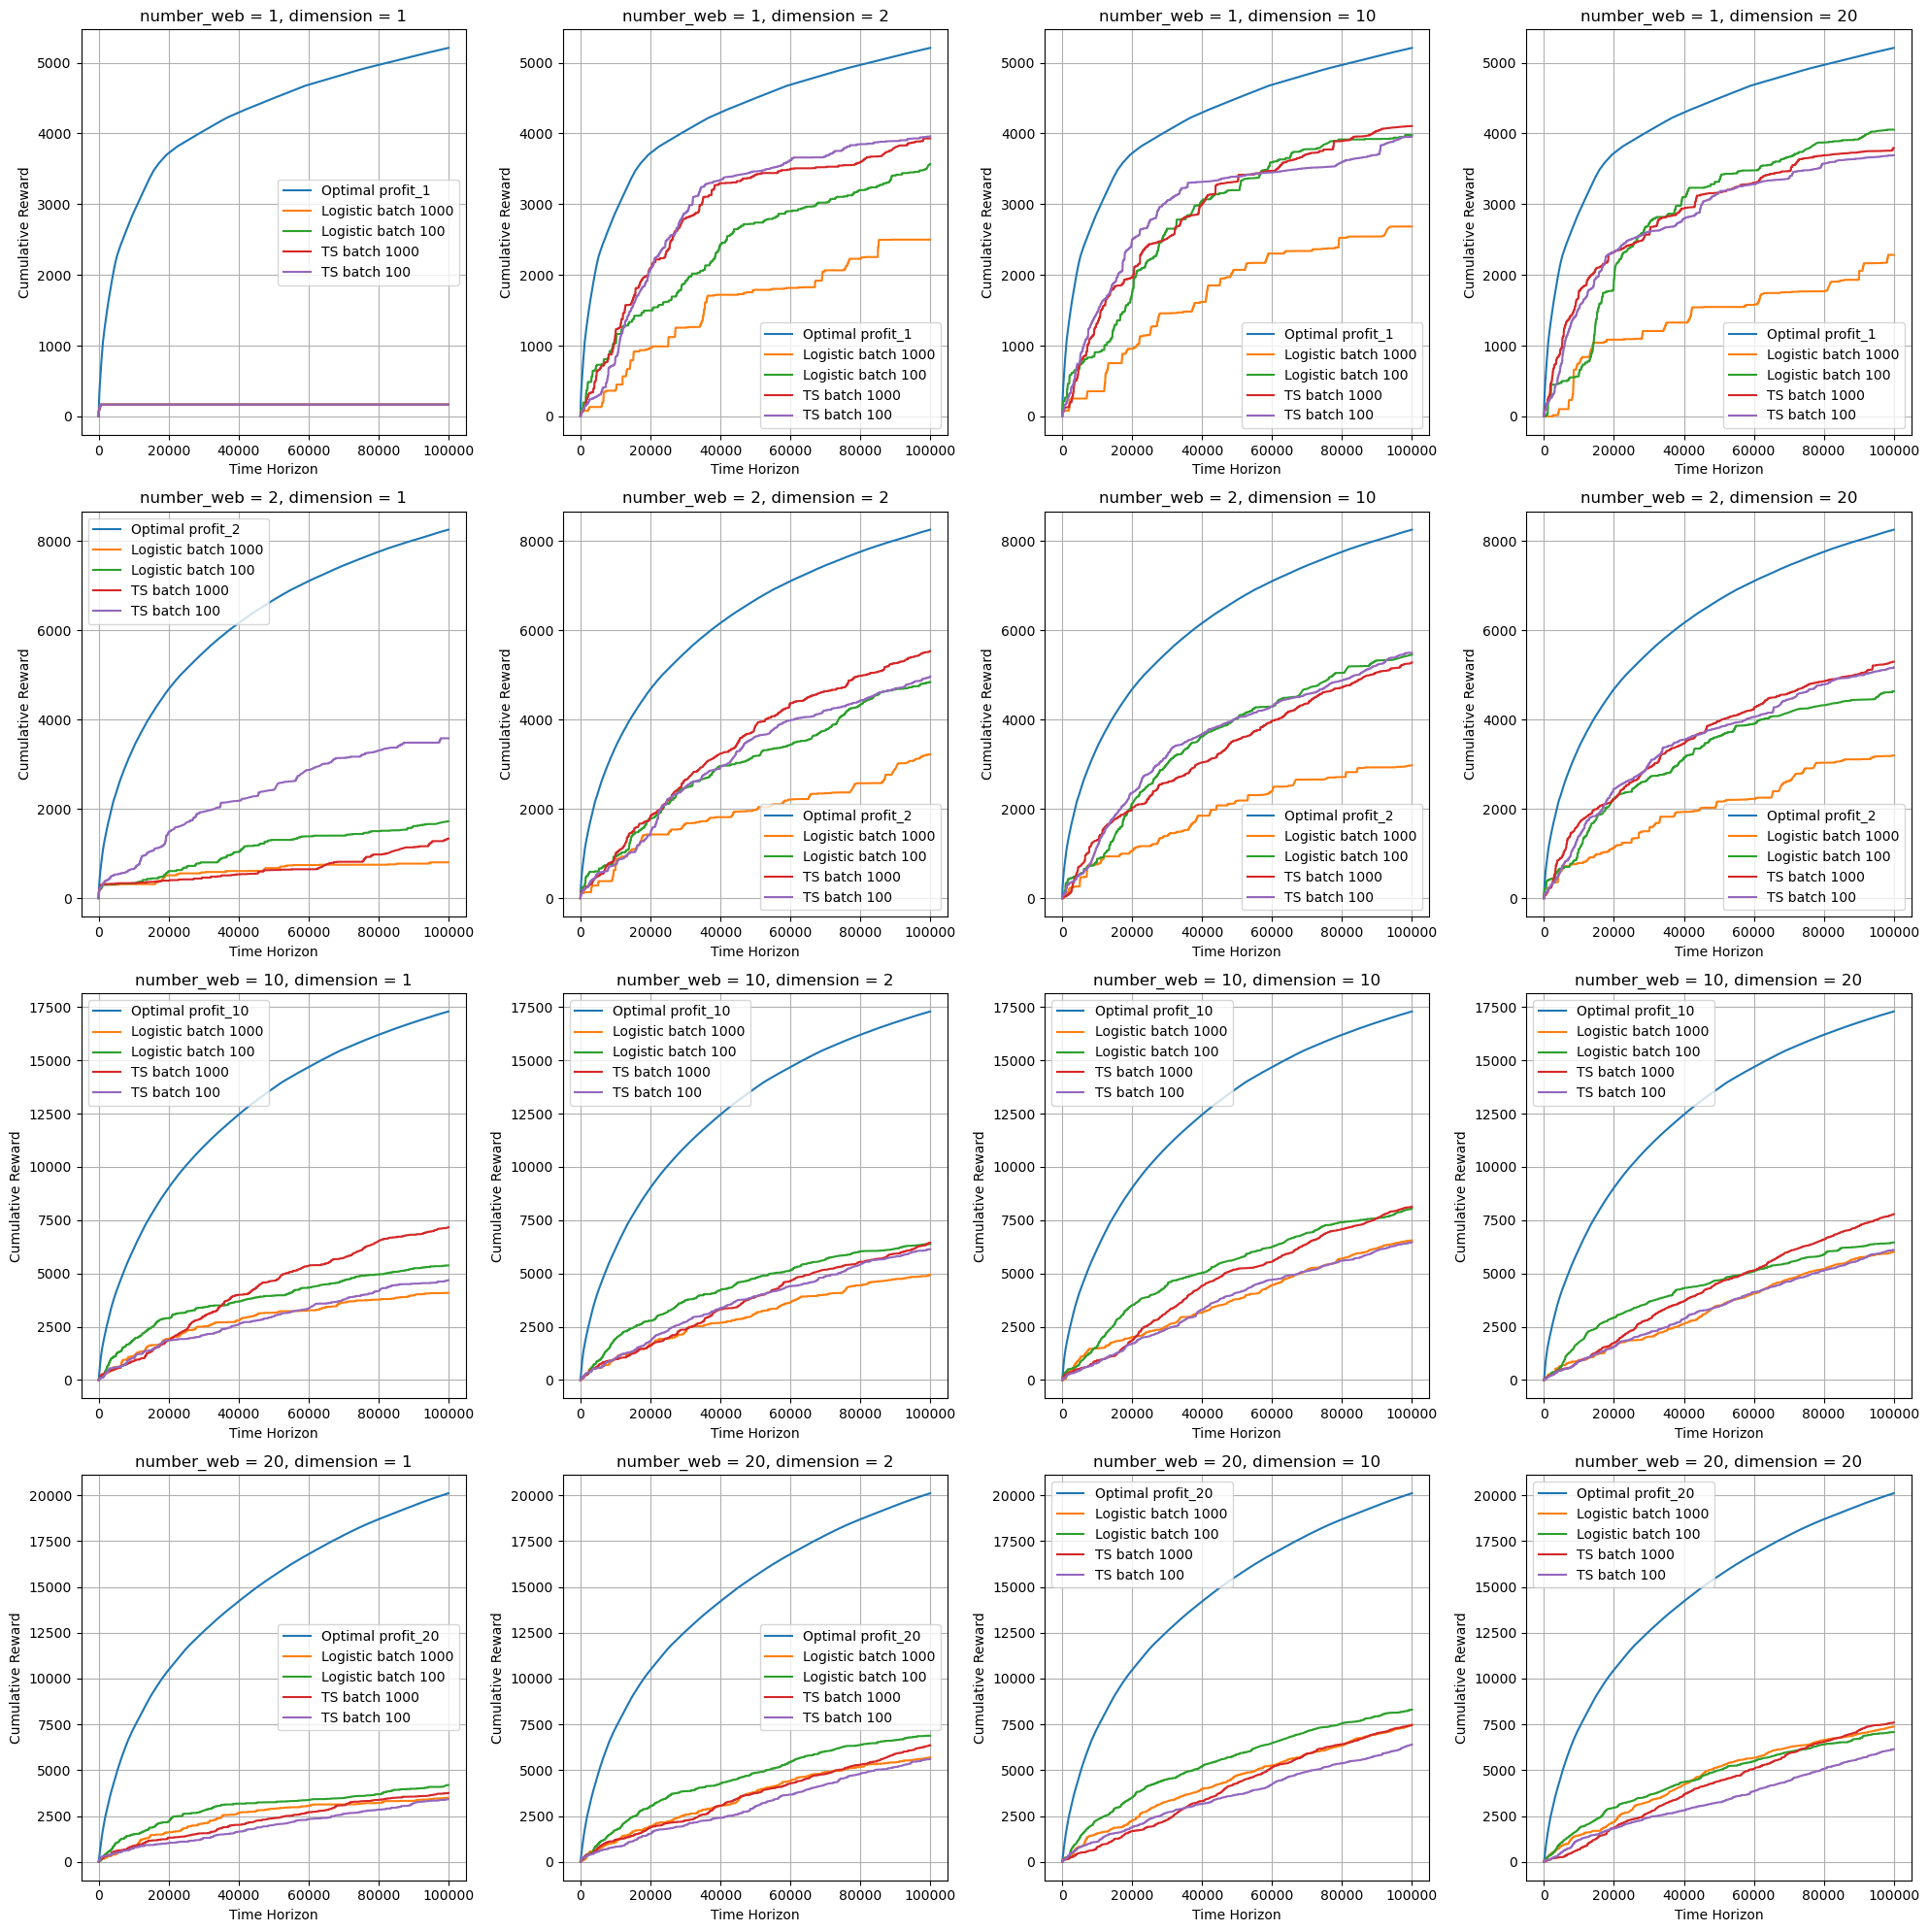

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Define the grid size
fig, axes = plt.subplots(4, 4, figsize=(20, 20))  # 4x4 grid, adjust figsize as needed
axes = axes.flatten()  # Flatten to make indexing easier

# Loop over the different `l` and `d` values
for i, l in enumerate([1, 2, 10, 20]):
    for j, d in enumerate([1, 2, 10, 20]):
        ax = axes[i*4 + j]  # Access the subplot
        
        # Plot the data
        ax.plot(np.arange(len(TS_optimal_dict_1000[f'optimal_{l}_{1}'])),
                TS_optimal_dict_1000[f'optimal_{l}_{1}']['revenue_org'].cumsum(),
                label=f'Optimal profit_{l}')
        
        ax.plot(np.arange(len(Lg_dict_1000[f'visit_{l}_{d}'])),
                Lg_dict_1000[f'visit_{l}_{d}']['revenue'].cumsum(),
                label=f'Logistic batch 1000')
        
        ax.plot(np.arange(len(Lg_dict_100[f'visit_{l}_{d}'])),
                Lg_dict_100[f'visit_{l}_{d}']['revenue'].cumsum(),
                label=f'Logistic batch 100')

        ax.plot(np.arange(len(TS_dict_1000[f'visit_{l}_{d}'])),
                TS_dict_1000[f'visit_{l}_{d}']['revenue'].cumsum(),
                label=f'TS batch 1000')
        
        ax.plot(np.arange(len(TS_dict_100[f'visit_{l}_{d}'])),
                TS_dict_100[f'visit_{l}_{d}']['revenue'].cumsum(),
                label=f'TS batch 100')
        
        # Set the title for the subplot
        ax.set_title(f'number_web = {l}, dimension = {d}')
        ax.grid(True)
        ax.legend()
        
        # Label the axes
        ax.set_xlabel('Time Horizon')
        ax.set_ylabel('Cumulative Reward')

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()
